In [1]:

import datetime
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import numpy as np
import requests
from functools import reduce
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

C:\Users\liuliu\anaconda3\envs\invest_agent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df=pd.read_csv("df_combined.csv", index_col=False)

In [3]:
df = df.iloc[:, 1:]
df.set_index('date', inplace=True)
df.index = pd.DatetimeIndex(df.index, freq='MS')

In [4]:
df

,bond_yield_1_yr,bond_yield_5_yr,bond_yield_10_yr,us_funds_rate,cpi_yoy,production_yoy,v39050,v39078,v39079
date,,,,,,,,,
2017-06-01,0.68,0.58,1.61,1.04,1.006945,7.074822,0.4987,0.75,0.50
2017-07-01,0.74,0.74,1.96,1.15,1.163647,4.475888,0.4970,0.75,0.50
2017-08-01,0.74,0.70,1.84,1.16,1.398626,2.618871,0.7475,1.00,0.75
2017-09-01,1.01,0.83,2.13,1.15,1.552801,1.699856,0.7588,1.00,0.75
2017-10-01,0.90,0.76,2.04,1.15,1.394292,1.557148,0.9693,1.25,1.00
...,...,...,...,...,...,...,...,...,...
2024-12-01,3.14,1.54,3.29,4.48,1.831979,-0.105260,3.7512,4.00,3.75
2025-01-01,2.96,1.45,3.18,4.33,1.895142,0.143734,3.2987,3.50,3.25
2025-02-01,2.84,1.33,2.98,4.33,2.644828,0.000000,3.0080,3.25,3.00


In [5]:
# Prophet requires columns 'ds' (date) and 'y' (target)
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'v39078': 'y'})

In [6]:
column_feature=['bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy']

In [7]:
del df_prophet['v39050']
del df_prophet['v39079']
df_prophet

,ds,bond_yield_1_yr,bond_yield_5_yr,bond_yield_10_yr,us_funds_rate,cpi_yoy,production_yoy,y
0,2017-06-01,0.68,0.58,1.61,1.04,1.006945,7.074822,0.75
1,2017-07-01,0.74,0.74,1.96,1.15,1.163647,4.475888,0.75
2,2017-08-01,0.74,0.70,1.84,1.16,1.398626,2.618871,1.00
3,2017-09-01,1.01,0.83,2.13,1.15,1.552801,1.699856,1.00
4,2017-10-01,0.90,0.76,2.04,1.15,1.394292,1.557148,1.25
...,...,...,...,...,...,...,...,...
90,2024-12-01,3.14,1.54,3.29,4.48,1.831979,-0.105260,4.00
91,2025-01-01,2.96,1.45,3.18,4.33,1.895142,0.143734,3.50
92,2025-02-01,2.84,1.33,2.98,4.33,2.644828,0.000000,3.25
93,2025-03-01,2.65,1.49,3.12,4.33,2.315346,0.000000,3.25


In [8]:
train_size = int(len(df) * 0.85)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

print(f"Training period: {df_train['ds'].iloc[0].date()} to {df_train['ds'].iloc[-1].date()}")
print(f"Testing period: {df_test['ds'].iloc[0].date()} to {df_test['ds'].iloc[-1].date()}")

Training period: 2017-06-01 to 2024-01-01
Testing period: 2024-02-01 to 2025-04-01


In [9]:
# Step 4: Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True,  # Enable yearly seasonality
    weekly_seasonality=False,  # Disable weekly (not relevant for monthly data)
    daily_seasonality=False,   # Disable daily (not relevant for monthly data)
    changepoint_prior_scale=0.5  # Increase flexibility for changepoints (e.g., COVID-19)
)


In [10]:
for var in column_feature:
    model.add_regressor(var)

In [11]:
model.fit(df_train)

05:03:55 - cmdstanpy - INFO - Chain [1] start processing
05:03:56 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
test_dates = df_test['ds']

In [13]:
future_dates = pd.date_range(start='2025-05-01', end='2025-10-01', freq='MS')
# Combine test and future dates
all_dates = pd.concat([pd.Series(test_dates), pd.Series(future_dates)], ignore_index=True)
future_df = pd.DataFrame({'ds': all_dates})

In [14]:
last_exog = df_prophet[column_feature].iloc[-1]
for var in column_feature:
    # Test period: use actual values
    future_df.loc[future_df['ds'].isin(test_dates), var] = df_test[var].values
    # Future period: use last known values
    future_df.loc[~future_df['ds'].isin(test_dates), var] = last_exog[var]

In [15]:
forecast = model.predict(future_df)

In [16]:
test_forecast = forecast[forecast['ds'].isin(test_dates)]

# Step 8: Evaluate test period forecast
rmse = np.sqrt(mean_squared_error(df_test['y'], test_forecast['yhat']))
print(f'RMSE: {rmse}')


RMSE: 0.351024154219207


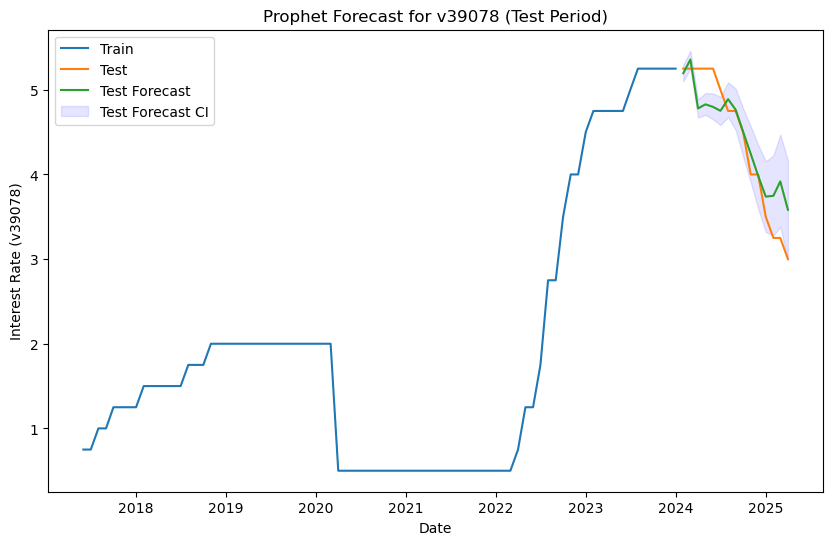

In [17]:
# Plot train, test, and forecast
plt.figure(figsize=(10, 6))
plt.plot(df_train['ds'], df_train['y'], label='Train')
plt.plot(df_test['ds'], df_test['y'], label='Test')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='blue', alpha=0.1, label='Test Forecast CI')
plt.title('Prophet Forecast for v39078 (Test Period)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (v39078)')
plt.legend()
plt.show()

In [18]:
#Retrain
model1 = Prophet(
    yearly_seasonality=True,  # Enable yearly seasonality
    weekly_seasonality=False,  # Disable weekly (not relevant for monthly data)
    daily_seasonality=False,   # Disable daily (not relevant for monthly data)
    changepoint_prior_scale=0.5  # Increase flexibility for changepoints (e.g., COVID-19)
)
for var in column_feature:
    model1.add_regressor(var)
model1.fit(df_prophet)

05:03:57 - cmdstanpy - INFO - Chain [1] start processing
05:03:58 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future_exog = df_prophet.iloc[-1:].copy()
# Repeat the last row 6 times while keeping it as a DataFrame
future_exog = pd.DataFrame(
    np.repeat(future_exog.values, 6, axis=0),
    columns=future_exog.columns,
    index=pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
)
future_exog['ds']=future_exog.index
future_exog

,ds,bond_yield_1_yr,bond_yield_5_yr,bond_yield_10_yr,us_funds_rate,cpi_yoy,production_yoy,y
2025-05-01,2025-05-01,2.65,1.6,3.07,4.33,1.805743,0.0,3.0
2025-06-01,2025-06-01,2.65,1.6,3.07,4.33,1.805743,0.0,3.0
2025-07-01,2025-07-01,2.65,1.6,3.07,4.33,1.805743,0.0,3.0
2025-08-01,2025-08-01,2.65,1.6,3.07,4.33,1.805743,0.0,3.0
2025-09-01,2025-09-01,2.65,1.6,3.07,4.33,1.805743,0.0,3.0
2025-10-01,2025-10-01,2.65,1.6,3.07,4.33,1.805743,0.0,3.0


In [20]:
forecast = model1.predict(future_exog)

In [58]:
df_output_test=test_forecast[['ds','yhat_lower','yhat_upper','yhat','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy']]
df_output_future=forecast[['ds','yhat_lower','yhat_upper','yhat','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy']]
df_output_test['type']='test'
df_output_future['type']='future'
df_output_test['model']='Prophet'
df_output_future['model']='Prophet'

union_df = pd.concat([df_output_test,df_output_future ])
union_df = union_df.rename(columns={'ds': 'date' })
union_df['model']='Prophet'


In [59]:
df_orig=df_prophet[['ds','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy','y']].copy()


In [61]:
df_orig=df_orig.merge(df_output_test[['ds','yhat','model','type']],  how='left', left_on='ds', right_on='ds')


In [62]:
union_df = pd.concat([df_orig,df_output_future[['ds','bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy','yhat','model','type']] ])

In [63]:
union_df['model']='Prophet'
union_df['type']=union_df['type'].fillna('train')
union_df.to_csv("model_forecast_prophet.csv",index=False)